In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import qutip as qt
import scipy as sp
from scipy import linalg
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random
from matplotlib import rc
from cycler import cycler
import time
import pandas as pd
from datetime import date
from Ps_library_temp import *
from Hamiltonian_library import *
from config import *
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':25})
rc('text', usetex=True)

# Multi-train scheme, without pre-initializing train.

In [107]:
system = Ps_system(N_points=100)
sequence = laser_sequence()
rabi0 = 2*np.pi*(600e-3)
chirp = 2*np.pi*(2500e-3)
detuning = 0#2*np.pi*(250e-3)
direction = 1
pulse_duration = 1
system.flag_SE_distributive = True
system.flag_photoionisation = True
print(system.std_deviation)
handler = data_handler()
opts = qt.Options(store_states=True)
saved_states = []
results = []
stds = []
expect_ph = []
directory = "./data/multi_train_ideal_test/"
system.init_distribution_MB()

cooling_kwargs = {               
    "scale":100,
    "rabi0" : rabi0,
    "pulse_duration" : pulse_duration,
    "start":0,
    "end":int(3*pulse_duration)
    }

no_laser_kwargs = {
    "scale":100,
    "rabi0" : 0,
    "detuning0": 0,
    "chirp" : 0,
    "pulse_duration" : pulse_duration,
    "unit_wavevector":direction,
    "start":0,
    "end":4,
    "isSE" : True
    } 



4.771275352895774e-06
201
[8.97149497806281e-05, 9.898604456507014e-05, 0.00010910731909138448, 0.00012014468451305775, 0.00013216790324145384, 0.00014525068909947898, 0.00015947079707328678, 0.00017491010106377735, 0.00019165465796763397, 0.0002097947563523716, 0.0002294249479325301, 0.0002506440600061527, 0.000273555186973255, 0.000298265659032589, 0.00032488698614093614, 0.00035353477532177664, 0.00038432861942885063, 0.00041739195550607544, 0.0004528518909397852, 0.0004908389956733895, 0.0005314870588494292, 0.0005749328083604389, 0.0006213155919288966, 0.0006707770184983498, 0.0007234605589030386, 0.0007795111049921931, 0.0008390744866175901, 0.0009022969461487833, 0.0009693245704589938, 0.0010403026806253346, 0.0011153751799086336, 0.0011946838609193271, 0.0012783676732350245, 0.0013665619531103288, 0.0014593976173082439, 0.0015570003234820827, 0.0016594895999447437, 0.0017669779480749038, 0.0018795699210240433, 0.0019973611828002463, 0.0021204375522107448, 0.002248874036540864, 

In [31]:
directory = "./data/multi_train_ideal_desym_1ps_4SE_event_3/"
num_SE_events_after_train = 3
num_trains = np.floor(50/(3.2*num_SE_events_after_train))
j = 0
first_iter = True
count_total = 1
#desymmetrizer_qobj = qt.tensor(qt.qdiags(np.where(system.momentum_bins > 0,1,0),offsets=0),qt.Qobj([[1,1,0],[1,1,0],[0,0,1]]))
#print(qt.Qobj([[1,1,0],[1,1,0],[0,0,1]]))
while j < num_trains:
    cooling_kwargs["label"]="empty"
    cooling_kwargs["unit_wavevector"] = 1
    cooling_kwargs["detuning0"] = 0
    cooling_kwargs["chirp"] = 0
    sequence.init_pulse(cooling_kwargs)

    sorted_sequence = sequence.pull_sorted_sequence()
    laser = sorted_sequence[-1][1]

    system.create_composite(laser,None)
    # desymmetrize
    if first_iter:
        system.init_states_desymmetrized()
        states = system.states
        first_iter = False
    else:
        desymmetrizer_qobj = qt.tensor(qt.qdiags(np.where(system.momentum_bins > 0,1,0),offsets=0),qt.Qobj([[0,1,0],[1,0,0],[0,0,1]]))
        #desymmetrizer_qobj = qt.tensor(qt.qeye(system.N_points),qt.Qobj([[1,0,0],[1,1,0],[0,0,1]]))
        keep_state_qobj = qt.tensor(qt.qdiags(np.where(system.momentum_bins <=0,1,0),offsets=0),qt.Qobj([[1,0,0],[0,1,0],[0,0,1]]))
        states = (desymmetrizer_qobj*states.copy()*desymmetrizer_qobj.dag() + keep_state_qobj*states.copy()*keep_state_qobj.dag()).unit()
        
        #states = desymmetrizer_qobj*states.copy()
        
    std = handler.expect_standard_deviation(states,system.N_points)
    stds.append(std)
    std_curr = std
    std_next = 0 # variable is initialized so that it is ALWAYS smaller than std_curr
    
    k=0
    i=0

    filename = "{}_{}.csv".format(count_total,"desymmetrization"+str(j))
    
    path = directory+filename
    qt.qsave(result,path)
    count_total +=1
    
    while True:

        # send in cooling pulses until loop condition is broken
        
        cooling_kwargs["label"]="cooling"+str(k)
        cooling_kwargs["unit_wavevector"] = (-1)**i*direction
        cooling_kwargs["detuning0"] = (-1)**i*detuning
        cooling_kwargs["chirp"] = (-1)**i*chirp
        sequence.init_pulse(cooling_kwargs)
        sorted_sequence = sequence.pull_sorted_sequence()
        laser = sorted_sequence[-1][1]

        system.set_Hamiltonian_MT_general_laser(laser)
        result = qt.mesolve(system.H,tlist=laser.tlist,rho0 = states,e_ops = system.e_ops,c_ops=system.c_ops,options=opts)
        states = result.states[-1]
        std_next = handler.expect_standard_deviation(states,system.N_points)
        
    
        k+=1
        i+=1
        if std_next > std_curr:
            print("Minimum reached for train of pulses...")
            i-=1
            break    

        
        print("std: {}".format(std_curr))
        stds.append(std_next)
        std_curr = std_next

        system.states = states
        
        filename = "{}_{}.csv".format(count_total,"cooling"+str(k))
        path = directory+filename
        qt.qsave(result,path)
        count_total +=1

    # wait for spontaneous emission

    no_laser_kwargs["label"] = "no_laser"+str(j)
    sequence.init_pulse(no_laser_kwargs)
    sorted_sequence = sequence.pull_sorted_sequence()
    laser = sorted_sequence[-1][1]

    SE_rate_fast = 1
    system.create_composite(laser,SE_rate_fast)
    
    system.set_Hamiltonian_MT_general_laser(laser)
    result = qt.mesolve(system.H,tlist=laser.tlist,rho0 = states,e_ops = system.e_ops,c_ops=system.c_ops,options=opts)
    states = result.states[-1]
    system.states = states
    

    stds.append( handler.expect_standard_deviation(states,system.N_points))
    j+=1
    
    filename = "{}_{}.csv".format(count_total,"SE"+str(j))
    
    path = directory+filename
    qt.qsave(result,path)
    count_total +=1


std: 31.516278006823484
std: 30.718336325399868
std: 29.933782036851497
std: 29.163654487379347
std: 28.40907312001411
std: 27.67124384707559
std: 26.951505635902983
std: 26.251293332412676
std: 25.57218290880026
std: 24.915856414963056
std: 24.2841286795661
std: 23.678924719709503
std: 23.10229389475778
std: 22.556422021999833
std: 22.04354711529705
std: 21.56600913855893
std: 21.126145447877924
std: 20.72632402615356
std: 20.36886837256666
std: 20.055983198573813
std: 19.789767797384496
std: 19.57205513149392
std: 19.40445522259263
std: 19.288234800328247
std: 19.22429359075348
Minimum reached for train of pulses...
std: 19.26042085032979
std: 18.500059327100757
std: 17.764286269046398
std: 17.056285199041504
std: 16.37965844313618
std: 15.738356555364012
std: 15.136780298558238
std: 14.579772966479961
std: 14.072662319899623
std: 13.620962999052727
std: 13.230261370684957
std: 12.90611406232338
std: 12.65358496807078
std: 12.476982096380743
std: 12.37952081725282
Minimum reached for

In [97]:
directory = "./data/multi_train_ideal_desym_1ps_4SE_event_2/"
no_laser_kwargs = {
    "label":"no_laser",
    "scale":10,
    "rabi0" : 0,
    "detuning0": 0,
    "chirp" : 0,
    "pulse_duration" : pulse_duration,
    "unit_wavevector":direction,
    "start":0,
    "end":1,
    "isSE" : True
    } 
count_total = 0 # total number of files per SE_time

sequence.init_pulse(no_laser_kwargs)
sorted_sequence = sequence.pull_sorted_sequence()
laser = sorted_sequence[-1][1]

SE_rate_fast = 1
system.create_composite(laser,SE_rate_fast)

files = os.listdir(directory)
files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))
fig,ax = plt.subplots()

file = files_sorted[0]
path = directory+file
result = qt.qload(path)
system.organise_result(result)
#ax.vlines(x=0,ymin=0,ymax=0.01)
#ax.plot(system.velocity_bins,system.expect["1S"][0],label="1S")
#ax.plot(system.velocity_bins,system.expect["2P"][0],label="2P")
ax.plot(system.velocity_bins,system.expect["1S"][0]+system.expect["2P"][0],label="total")
#print(system.momentum_bins)
#print(system.velocity_bins,system.expect["1S"][0]+system.expect["2P"][0])
file = files_sorted[-1]
path = directory+file
result = qt.qload(path)
system.organise_result(result)
#ax.plot(system.velocity_bins,system.expect["1S"][-1],label="final")

plt.ylabel("Population")
plt.xlabel("velocity [cm/ps]")


plt.legend()
#plt.savefig("./figures/thesis/doppler_final_state_1ps.svg")
plt.show()

In [47]:
directory = "./data/multi_train_ideal_desym_1ps_1SE_event_2/"


files = os.listdir(directory)
files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))
fig,ax = plt.subplots()



array = []
for i in range(len(files_sorted)):
    file = files_sorted[i]
    path = directory+file
    result = qt.qload(path)
    system.organise_result(result)
    
    new_arr = system.expect["1S"][-1]+system.expect["2P"][-1]#+system.expect["ph."][-1]
    array.append(new_arr)

plt.imshow(np.float128(np.asarray(array)).T,aspect="auto",origin="lower")
ticks = [0,50,100,150,200]
plt.yticks(ticks, ["{:.1e}".format(system.velocity_bins[tick]) for tick in ticks])
plt.colorbar()
plt.ylabel("velocity [cm/ps]")
plt.xlabel("number of pulses")
#plt.savefig("./figures/thesis/doppler_evolution_1ps.svg")
plt.show()

/home/yanai/anaconda3/envs/lasers/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


25_cooling25.csv
[31.516278006823484, 30.718336325399868, 29.933782036851497, 29.163654487379347, 28.40907312001411, 27.67124384707559, 26.951505635902983, 26.251293332412676, 25.57218290880026, 24.915856414963056, 24.2841286795661, 23.678924719709503, 23.10229389475778, 22.556422021999833, 22.04354711529705, 21.56600913855893, 21.126145447877924, 20.72632402615356, 20.36886837256666, 20.055983198573813, 19.789767797384496, 19.57205513149392, 19.40445522259263, 19.288234800328247, 19.22429359075348, 19.21312791886601]


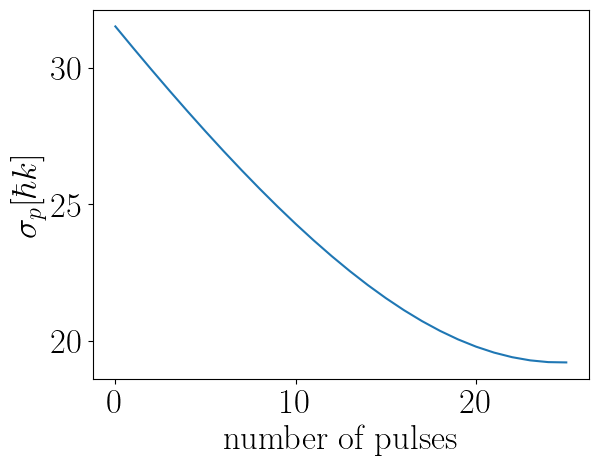

In [104]:
directory = "./data/multi_train_ideal_desym_1ps_4SE_event_2/"
handler = data_handler()

files = os.listdir(directory)
files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))

N_points = 201
file = files_sorted[0]
path = directory+file
result = qt.qload(path)
stds = [handler.expect_standard_deviation(result.states[0],N_points)]

for i in range(25):
    file = files_sorted[i]
    path = directory+file
    result = qt.qload(path)
    #print(path)
    stds.append(handler.expect_standard_deviation(result.states[-1],N_points))
    
print(stds)
np.savetxt("sigma_p_data.txt",stds)
fig,ax = plt.subplots()
ax.plot(np.arange(len(stds)),stds)
plt.xlabel("number of pulses")
plt.ylabel(r"$\sigma_p [\hbar k]$")
plt.show()

31.912581289938256 30.72644329388822


Text(0, 0.5, '$\\sigma_p [\\hbar k]$')

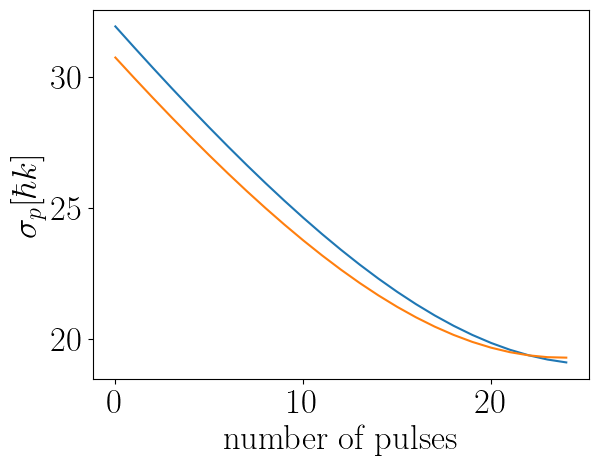

In [72]:
directory = "./data/archive/ideal_desym_1ps_noSE/"
handler = data_handler()

files = os.listdir(directory)
files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))

file = files_sorted[0]
path = directory+file
result = qt.qload(path)

initial_state = result.states[0]
stds_theoretical = handler.expect_std_theoretical(initial_state,201,system.momentum_bins)

stds_simulation = []
N_points = 201
for i in range(25):
    file = files_sorted[i]
    path = directory+file
    result = qt.qload(path)
    #print(path)
    stds_simulation.append(handler.expect_standard_deviation(result.states[-1],N_points))
print(stds_theoretical[0],stds_simulation[0])
fig,ax = plt.subplots()
#ax.plot(np.arange(25),stds_simulation-stds_theoretical)
ax.plot(np.arange(25),stds_theoretical)
ax.plot(np.arange(25),stds_simulation)
plt.xlabel("number of pulses")
plt.ylabel(r"$\sigma_p [\hbar k]$")

# Spontaneous emission lifetime between pulses

In [2]:
system = Ps_system(N_points=100)
sequence = laser_sequence()
rabi0 = 2*np.pi*(150e-3)
chirp = 2*np.pi*(250e-3)
detuning = 0#2*np.pi*(250e-3)
direction = 1
pulse_duration = 10
system.flag_SE_distributive = True
system.flag_photoionisation = True

handler = data_handler()
opts = qt.Options(store_states=True)
saved_states = []
results = []
stds = []
expect_ph = []
system.init_distribution_MB()

cooling_kwargs = {               
    "scale":1000,
    "rabi0" : rabi0,
    "pulse_duration" : pulse_duration,
    "start":0,
    "end":int(3*pulse_duration)
    }

directory = "./data/SE_scan5/"

j = 0 # SE counter for saving results to file
l = 0 # desymmetrization counter 
idx_SE = 0 # counter for SE times
first_iter = True

SE_times = [0.04,0.06,0.11,0.13,0.19,0.21,0.28,0.3,0.37,0.4,0.47,0.5,0.59,0.61,0.72,0.75,0.87,0.9,1.04,1.08,1.26,1.3,1.53,1.57,1.92,1.96,2.55,2.6,4.6,4.7,5.0,5.5,0.06,0.13,0.21,0.3,0.39,0.5,0.61,0.74,0.89,1.27,1.55,1.91,2.5,3.9] # scan3
#SE_times = [0.04,0.05,0.052,0.1225,0.1245,0.2009,0.2029,0.2849,0.2889,0.3778,0.3818,0.4803,0.4843,0.5944,0.5984,0.7234,0.7274,0.8714,0.8754,1.0451,1.0491,1.2555,1.2595,1.5224,1.5264,1.8875,1.8915,2.4684,2.4724,4.000,4.040,5] # scan4
SE_times = [0.06,0.13,0.21,0.3,0.39,0.5,0.61,0.74,0.89,1.27,1.55,1.91,2.5,3.9] # scan5, additional measurements
file_path = "./data/initial_state_for_SE_sims/25_cooling25_1psLaser.csv"
for SE_time in SE_times:

    """
    Initialize state after last cooling pulse from previous train, and then wait SE_time number with just SE
    """    
    
    no_laser_kwargs = {
    "scale":10,
    "rabi0" : 0,
    "detuning0": 0,
    "chirp" : 0,
    "pulse_duration" : pulse_duration,
    "unit_wavevector":direction,
    "start":0,
    "end":SE_time,
    "isSE" : True
    } 
    count_total = 0 # total number of files per SE_time
    result = qt.qload(file_path)
    states = result.states[-1].copy()

    no_laser_kwargs["label"] = "no_laser"+str(j)
    sequence.init_pulse(no_laser_kwargs)
    sorted_sequence = sequence.pull_sorted_sequence()
    laser = sorted_sequence[-1][1]

    SE_rate_fast = 1
    system.create_composite(laser,SE_rate_fast)
    
    system.set_Hamiltonian_MT_general_laser(laser)
    result = qt.mesolve(system.H,tlist=laser.tlist,rho0 = states,e_ops = system.e_ops,c_ops=system.c_ops,options=opts)
    states = result.states[-1].copy()

    stds.append( handler.expect_standard_deviation(states,system.N_points))
    j+=1
    
    filename = "SE{}_{}_{}.csv".format(idx_SE,count_total,"SE"+str(j))
    
    path = directory+filename
    qt.qsave(result,path)
    count_total +=1
    print("Waited {} SE lifetimes".format(SE_time))
    
    
    """
    Desymmetrization
    """

    desymmetrizer_qobj = qt.tensor(qt.qdiags(np.where(system.momentum_bins > 0,1,0),offsets=0),qt.Qobj([[0,1,0],[1,0,0],[0,0,1]]))
    keep_state_qobj = qt.tensor(qt.qdiags(np.where(system.momentum_bins <=0,1,0),offsets=0),qt.Qobj([[1,0,0],[0,1,0],[0,0,1]]))
    states = (desymmetrizer_qobj*states.copy()*desymmetrizer_qobj.dag() + keep_state_qobj*states.copy()*keep_state_qobj.dag()).unit()
    
    std = handler.expect_standard_deviation(states,system.N_points)
    stds.append(std)
    std_curr = std
    std_next = 0 # variable is initialized so that it is ALWAYS smaller than std_curr
    l +=1

    # filename = "SE{}_{}_{}.csv".format(idx_SE,count_total,"desymmetrization"+str(l))
    
    # path = directory+filename
    # qt.qsave(result,path)
    # count_total +=1
    print("Desymmetrization done")
    k=0
    i=0    

    """
    Send in cooling pulses until you reach the minimum momentum spread
    """
    while True:

        # send in cooling pulses until loop condition is broken
        
        cooling_kwargs["label"]="cooling"+str(k)
        cooling_kwargs["unit_wavevector"] = (-1)**i*direction
        cooling_kwargs["detuning0"] = (-1)**i*detuning
        cooling_kwargs["chirp"] = (-1)**i*chirp
        sequence.init_pulse(cooling_kwargs)
        sorted_sequence = sequence.pull_sorted_sequence()
        laser = sorted_sequence[-1][1]
        
        system.set_Hamiltonian_MT_general_laser(laser)
        system.create_composite(laser,None)
        result = qt.mesolve(system.H,tlist=laser.tlist,rho0 = states,e_ops = system.e_ops,c_ops=system.c_ops,options=opts)
        states = result.states[-1].copy()
        std_next = handler.expect_standard_deviation(states,system.N_points)
        
    
        k+=1
        i+=1
        if std_next > std_curr:
            print("Minimum reached for train of pulses...")
            i-=1
            break    

        
        print("std: {}".format(std_curr))
        stds.append(std_next)
        std_curr = std_next
        
        filename = "SE{}_{}_{}.csv".format(idx_SE,count_total,"cooling"+str(k))
        path = directory+filename
        qt.qsave(result,path)
        count_total +=1

    # wait for spontaneous emission

    no_laser_kwargs["label"] = "no_laser"+str(j)
    sequence.init_pulse(no_laser_kwargs)
    sorted_sequence = sequence.pull_sorted_sequence()
    laser = sorted_sequence[-1][1]

    SE_rate_fast = 1
    system.create_composite(laser,SE_rate_fast)
    
    system.set_Hamiltonian_MT_general_laser(laser)
    result = qt.mesolve(system.H,tlist=laser.tlist,rho0 = states,e_ops = system.e_ops,c_ops=system.c_ops,options=opts)
    states = result.states[-1]    

    stds.append( handler.expect_standard_deviation(states,system.N_points))
    j+=1
    
    filename = "SE{}_{}_{}.csv".format(idx_SE,count_total,"SE"+str(j))
    
    path = directory+filename
    qt.qsave(result,path)
    count_total +=1
    idx_SE +=1


201
[8.97149497806281e-05, 9.898604456507014e-05, 0.00010910731909138448, 0.00012014468451305775, 0.00013216790324145384, 0.00014525068909947898, 0.00015947079707328678, 0.00017491010106377735, 0.00019165465796763397, 0.0002097947563523716, 0.0002294249479325301, 0.0002506440600061527, 0.000273555186973255, 0.000298265659032589, 0.00032488698614093614, 0.00035353477532177664, 0.00038432861942885063, 0.00041739195550607544, 0.0004528518909397852, 0.0004908389956733895, 0.0005314870588494292, 0.0005749328083604389, 0.0006213155919288966, 0.0006707770184983498, 0.0007234605589030386, 0.0007795111049921931, 0.0008390744866175901, 0.0009022969461487833, 0.0009693245704589938, 0.0010403026806253346, 0.0011153751799086336, 0.0011946838609193271, 0.0012783676732350245, 0.0013665619531103288, 0.0014593976173082439, 0.0015570003234820827, 0.0016594895999447437, 0.0017669779480749038, 0.0018795699210240433, 0.0019973611828002463, 0.0021204375522107448, 0.002248874036540864, 0.002382733860228225, 

[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.         2.08333333 2.16666667 2.25       2.33333333 2.41666667
 2.5        2.58333333 2.66666667 2.75       2.83333333 2.91666667
 3.         3.08333333 3.16666667 3.25       3.33333333 3.41666667
 3.5        3.58333333 3.66666667 3.75       3.83333333 3.91666667
 4.         4.08333333 4.16666667 4.25       4.33333333 4.41666667
 4.5        4.58333333 4.66666667 4.75       4.83333333 4.91666667
 5.        ]


['SE29_0_SE59.csv', 'SE27_0_SE55.csv', 'SE24_0_SE49.csv', 'SE2_0_SE5.csv', 'SE31_0_SE63.csv', 'SE22_0_SE45.csv', 'SE4_0_SE9.csv', 'SE11_0_SE23.csv', 'SE16_0_SE33.csv', 'SE10_0_SE21.csv', 'SE26_0_SE53.csv', 'SE19_0_SE39.csv', 'SE13_0_SE27.csv', 'SE0_0_SE1.csv', 'SE30_0_SE61.csv', 'SE7_0_SE15.csv', 'SE12_0_SE25.csv', 'SE17_0_SE35.csv', 'SE8_0_SE17.csv', 'SE21_0_SE43.csv', 'SE3_0_SE7.csv', 'SE23_0_SE47.csv', 'SE15_0_SE31.csv', 'SE18_0_SE37.csv', 'SE14_0_SE29.csv', 'SE5_0_SE11.csv', 'SE6_0_SE13.csv', 'SE9_0_SE19.csv', 'SE28_0_SE57.csv', 'SE20_0_SE41.csv', 'SE25_0_SE51.csv', 'SE1_0_SE3.csv', 'SE2_0_SE5.csv', 'SE4_0_SE9.csv', 'SE11_0_SE23.csv', 'SE10_0_SE21.csv', 'SE13_0_SE27.csv', 'SE0_0_SE1.csv', 'SE7_0_SE15.csv', 'SE12_0_SE25.csv', 'SE8_0_SE17.csv', 'SE3_0_SE7.csv', 'SE5_0_SE11.csv', 'SE6_0_SE13.csv', 'SE9_0_SE19.csv', 'SE1_0_SE3.csv', 'SE3_1_cooling1.csv', 'SE22_1_cooling1.csv', 'SE17_1_cooling1.csv', 'SE10_1_cooling1.csv', 'SE18_1_cooling1.csv', 'SE26_1_cooling1.csv', 'SE4_1_cooling1.cs

FileNotFoundError: [Errno 2] No such file or directory: './data/SE_scan4/SE13_16_SE28.csv'

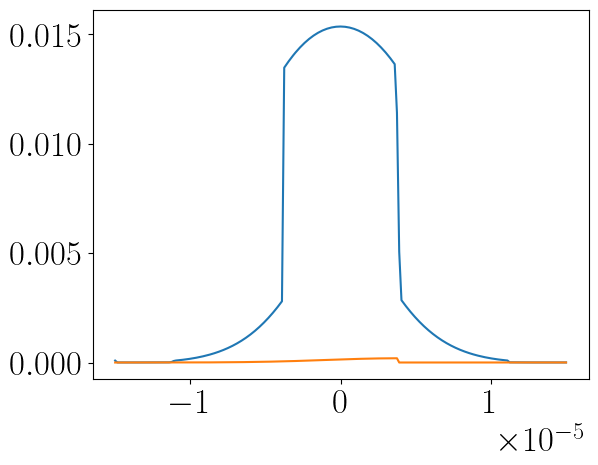

In [3]:
directory = "./data/SE_scan4/"
directory2 = "./data/SE_scan5/"

files = os.listdir(directory) + os.listdir(directory2)

files_sorted = sorted(files,key=lambda x:int(x.split("_")[1]))
print(files_sorted)
fig,ax = plt.subplots()

file = files_sorted[0]
path = directory+file
result = qt.qload(path)
system.organise_result(result)
#ax.vlines(x=0,ymin=0,ymax=0.01)
ax.plot(system.velocity_bins,system.expect["1S"][-1],label="1S")
ax.plot(system.velocity_bins,system.expect["2P"][-1],label="2P")
#ax.plot(system.velocity_bins,system.expect["1S"][-1]+system.expect["2P"][-1],label="total")

file = files_sorted[-1]
path = directory+file
result = qt.qload(path)
system.organise_result(result)
#ax.plot(system.velocity_bins,system.expect["1S"][-1],label="final")

plt.ylabel("Population")
plt.xlabel("velocity [cm/ps]")


plt.legend()
#plt.savefig("./figures/thesis/doppler_final_state_1ps.svg")
plt.show()

[1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 11, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15]


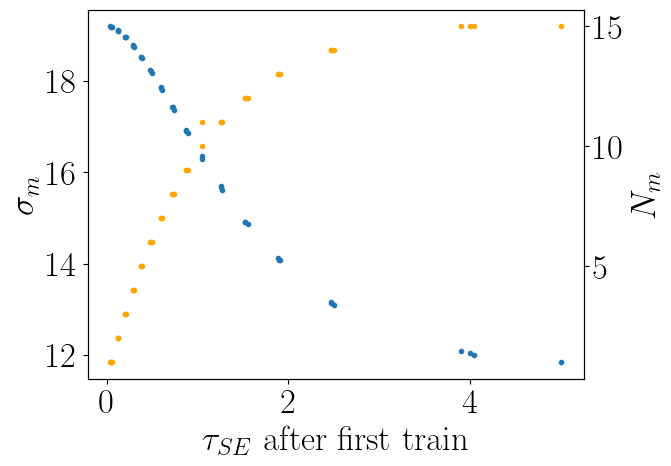

In [20]:
directory = "./data/SE_scan4/"
directory2 = "./data/SE_scan5/"
handler = data_handler()

files = os.listdir(directory)
files2 = os.listdir(directory2)

N_m_array = []
final_stds = []
#SE_times = [0.04,0.06,0.11,0.13,0.19,0.21,0.28,0.3,0.37,0.4,0.47,0.5,0.59,0.61,0.72,0.75,0.87,0.9,1.04,1.08,1.26,1.3,1.53,1.57,1.92,1.96,2.55,2.6,4.6,4.7,5.0] # scan3
SE_times = [0.04,0.05,0.052,0.1225,0.1245,0.2009,0.2029,0.2849,0.2889,0.3778,0.3818,0.4803,0.4843,0.5944,0.5984,0.7234,0.7274,0.8714,0.8754,1.0451,1.0491,1.2555,1.2595,1.5224,1.5264,1.8875,1.8915,2.4684,2.4724,4.000,4.040,5] # scan4
SE_times3 = [0.8,0.15,0.24,0.33,0.43,0.54,0.65,0.79,0.95,1.12,1.4,1.7,2.2,3.0,4.5] # scan6
for i in range(len(SE_times)):
    files_split_by_SE = [file for file in files if "SE"+str(i) in file.split("_")]
    files_sorted = sorted(files_split_by_SE,key=lambda x:int(x.split("_")[1]))
    last_in_train = files_sorted[-2]
    N_m_array.append(len(files_sorted) - 2) # size of list corresponds to the number of cooling pulses to reach minimum, and includes 2 SE time-sequences
    path = directory+last_in_train
    result = qt.qload(path)
    states = result.states[-1]
    final_stds.append(handler.expect_standard_deviation(states,system.N_points))

SE_times2 = [0.06,0.13,0.21,0.3,0.39,0.5,0.61,0.74,0.89,1.27,1.55,1.91,2.5,3.9] 
for i in range(len(SE_times2)):
    files_split_by_SE = [file for file in files2 if "SE"+str(i) in file.split("_")]
    files_sorted = sorted(files_split_by_SE,key=lambda x:int(x.split("_")[1]))
    last_in_train = files_sorted[-2]
    N_m_array.append(len(files_sorted) - 2) # size of list corresponds to the number of cooling pulses to reach minimum, and includes 2 SE time-sequences
    path = directory2+last_in_train
    result = qt.qload(path)
    states = result.states[-1]
    final_stds.append(handler.expect_standard_deviation(states,system.N_points))

fig,ax=plt.subplots()

ax.plot(SE_times+SE_times2,final_stds,'.')
ax.set_xlabel(r"$\tau_{SE}$ after first train")
ax.set_ylabel(r"$\sigma_m$")
ax2 = ax.twinx()
print(N_m_array)
ax2.plot(SE_times+SE_times2,N_m_array,'.',color='orange')
ax2.set_ylabel(r"$N_m$")
plt.show()


# Recreating fig 4 in paper

In [87]:
directory = "./data/multi_train_ideal_desym_1ps_1SE_event_2/"
handler = data_handler()
files = os.listdir(directory)

files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))

population_excited = []
times = []
total_time_temp = 0
time_cooling = 3 # ps
for file in files_sorted:
    chars_in_file_name = list(file.split("_")[1])
    if "".join(chars_in_file_name[0:7]) == "cooling":
        result = qt.qload(directory+file)
        #system.organise_result(result)
        states = result.states.copy()
        #population_excited.append(np.sum(system.expect["2P"][-1]))
        #print(np.shape(states)        )
        #total_time_temp += time_cooling
        #times.append(total_time_temp)
        
    elif "".join(chars_in_file_name[0:2]) == "SE":
        result = qt.qload(directory+file)
        states = result.states.copy()
        
        print(np.shape(states))
        #for i in range(np.size(states)):
            #population_excited.append(system.expect["2P"][i])

            
        #    times.append(total_time_temp+result.times[i]*3.2e3)
        #print(population_excited)
        #total_time_temp = times[-1]

print(times)
#plt.plot(times,population_excited)

(12, 603, 603)
(12, 603, 603)
(12, 603, 603)
(12, 603, 603)
(12, 603, 603)
(12, 603, 603)
(12, 603, 603)
(12, 603, 603)
(12, 603, 603)
(12, 603, 603)
(12, 603, 603)
(12, 603, 603)
(12, 603, 603)
(12, 603, 603)
(12, 603, 603)
[]
